# X: Creating Data Sets

##  Example 2, Part X: pH-Rate Profile Example - Kirby 2002

This notebook contains the code to make abs vs time data sets for the curve fit activity related to interpretting data from the following paper.

``Concerted general acid and nucleophilic catalysis of acetalhydrolysis. A simple model for the lysozyme mechanism''. K.E.S. Deana, A.J. Kirby, *J. Chem. Soc., Perkin Trans. 2*, **2002**, 428-432. https://doi.org/10.1039/B110948K. 


## Data Simulation

The authors provided no data on the extiction coeffiocients of the reactants and product. The relative extiction coefficients that will be used to create the data set are reasonable guesstimates based on similar compounds. The initial absorbance was chosen to be 0.1 as this resulted in all results remaining below 1.0 AU.

We will sue the numeric integration method already developed to get a list of concentrations for the species in the system. Then this will be used to calculate the total absorbance vs time. Finally random error will be applied to the values.

The data will be written out as an abs vs. time data set. Separate files will be created for each data set named according to a root file name and the pH value.

## Load in rate data

the code below will load in the data file containing rate data and create the lists of variables.

In [5]:
#######################
### Environment Setup and Global Variables
#######################

github = True

!mkdir data
!mkdir data/Kirby2002
!mkdir plots
!mkdir plots/fits
!mkdir plots/single
!mkdir plots/stacking

!pip install uncertainties
!pip install lmfit

if github:
    data_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_11/data/"
    image_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_11/images/"
    github_data_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"
    github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
else:
    data_path = "../Class_11/data/"
    image_path = "../Class_11/images/"
    github_data_location = "/Users/blink/github/LFER-QSAR/data/"
    github_styles_location = "/Users/blink/github/LFER-QSAR/styles/"


mkdir: data: File exists
mkdir: data/Kirby2002: File exists
mkdir: plots: File exists
mkdir: plots/fits: File exists
mkdir: plots/single: File exists
mkdir: plots/stacking: File exists


In [6]:
### from StealThisCode/4_SciPy/K05_NumericIntegration_SystemEq.ipynb

#######################
### import packages 
#######################

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

############################################
### Create a function that describes the 
### system of differential equations. 
############################################

def rates(t, c, k_1, k_2):  

    A = c[0]; I = c[1]; P = c[2]           ### assign initial conc. from input list c

    dA_dt = -k_1 * c[0]    ### rates of each reaction step with give concentration in list c
    dI_dt = k_1 * c[0]  - k_2 * c[1] 
    dP_dt = k_1 * c[0] + k_2 * c[1] 

    return [dA_dt, dI_dt, dP_dt]

df = pd.read_csv(data_path+"Fig1-Kirby2002_ForMakingData.csv",
                skipinitialspace=True,
                comment="#"
                )
display(df)

pH_array = df["pH"]
k1_array = 10**df["k_1"]
k2_array = 10**df["k_2"]


,pH,k_1,k_2
0,0.00,-2.95000,-3.19000
1,0.28,-3.29000,-3.54000
2,0.55,-3.63732,-3.88375
3,1.00,-3.87159,-4.21124
4,1.25,-4.15755,-4.47649
5,1.50,-4.16600,-4.79559
6,1.90,-4.16829,-5.09404
7,2.25,-4.07323,-5.27000
8,2.60,-3.89117,-5.33259
9,3.40,-3.47537,-5.41382


## Create Single Data File

The code below will write a single data file for a give row in the rate data set.

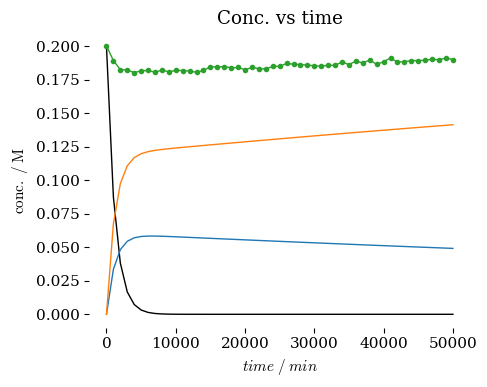

log(k1) = -3.08245
log(k2) = -5.39163


In [11]:
############################################
### Parameters and experimental conditions
############################################

n = 12                     ### row for data 

pH = pH_array[n]           ### pH values for this experiment
k_1 = k1_array[n]          ### Values for kinetic parameters
k_2 = k2_array[n]
A0_conc = 1

time_end = 50000   ### The end time
n_points = 50   ### number of points - increase if needed

#########################################
### Create series of time points      
#########################################

dt = time_end / n_points           ### time step, delta t
t_line = np.arange(0, time_end+dt, dt) ### time vector (list of time points)
num = len(t_line)

#########################################
### Integrate the system of differential equations      
#########################################

initial = [A0_conc, 0, 0]      ### Set list of initial values (A, I, P)

integration = solve_ivp(rates,                ### the function being integrated. 
                [0, time_end],        ### start and endpoint of integration
                initial,              ### initial values
                method = "Radau",     ### 'RK45', 'RK23', 'LSODA', 'DOP853', 'Radau', 'BDF'
                t_eval = t_line,      ### time points at which to calculate values
                first_step = 1e-5,    ### take a very small first step. the initial rate is much faster than the average slope.
                args = [k_1, k_2]  ### values to send to function after t and c
                )

#########################################
### Extract the results from the returned data object      
#########################################

time = integration.t        ### solve_inp() returns an array for time indexed as 't'
yarray = integration.y      ### Also retruns and array of calculated y values.
                    ###  if more than one value returned from function we will
                    ###  get a array of arrays for each value

## Plot Absorbances

############################################
### Parameters and experimental conditions
############################################

eA = 1         ### extinction coefficients (ratios)
eI = 0.3
eP = 0.6
Abs0 = 0.2     ### Initial absorbance

##################################################################################
### Plot the results
##################################################################################

plt.rcdefaults()                    ### resets the plot defaults so we always start in the same place
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

#########################################
### Plot the line using the x_fit, y_fit points
#########################################
x = time      
y = yarray[0] * Abs0 * eA / eA
ax.plot(x, y, 
        linestyle = '-',            ### use a line between points
 #       linewidth='0.5',            ### make the line thin
        color = 'C0',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )

x = time      
y = yarray[1]  * Abs0 * eI / eA
ax.plot(x, y, 
        linestyle = '-',            ### use a line between points
 #       linewidth='0.5',            ### make the line thin
        color = 'C1',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )

x = time      
y = yarray[2]  * Abs0 * eP / eA
ax.plot(x, y, 
        linestyle = '-',            ### use a line between points
 #       linewidth='0.5',            ### make the line thin
        color = 'C2',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )

x = time      
y = Abs0 * (yarray[0]*eA/eA + yarray[1]*eI/eA + yarray[2]* eP/eA)
y = np.random.normal(y, .001)   # add random gaussian error 

ax.plot(x, y, 
        marker = ".",
        linestyle = '-',            ### use a line between points
 #       linewidth='0.5',            ### make the line thin
        color = 'C3',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )

#########################################
### Add more style
#########################################
        
ax.set(ylabel=r"$\rm conc.\;/\;M $", 
        xlabel=r"$time\; /\; min$",
        title = "Conc. vs time",
        xlim=[None, None],      
        ylim=[None, None])


fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig("plot.pdf")    # use this to save the figure in PDF format
plt.show()                 # output the combined four plots

print(f"log(k1) = {np.log10(k_1):0.5f}")
print(f"log(k2) = {np.log10(k_2):0.5f}")


df2 = pd.DataFrame({"time": x, "Abs": y})
df2.to_csv("./data/Kirby2002_Abs_vs_time_for_pH_"+str(pH)+".csv")

## Create Multiple Data Files 

The code below is the same as above. I just put it in a loop to run through the lines in the data file.

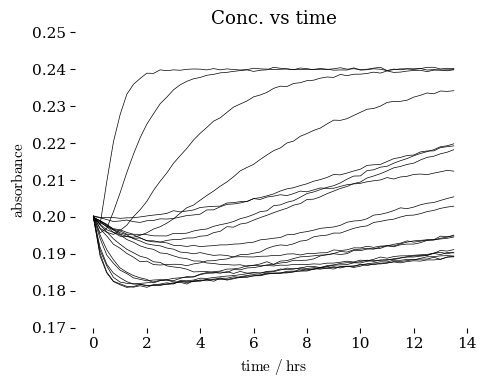

In [10]:
############################################
### Parameters and experimental conditions
############################################

A0_conc = 1

eA = 1         ### extinction coefficients (ratios)
eI = 0.3
eP = 0.6
Abs0 = 0.2     ### Initial absorbance

time_end = 13.5   ### The end time (hours)
n_points = 54   ### number of points - increase if needed

#########################################
### Create series of time points      
#########################################

dt = time_end / n_points           ### time step, delta t
t_line = np.arange(0, time_end+dt, dt) ### time vector (list of time points)

df3 = pd.DataFrame({"time (hr)": t_line})

t_line = t_line * 3600              ### time in seconds
time_end = time_end * 3600
num = len(t_line)

##################################################################################
### Plot the results
##################################################################################

plt.rcdefaults()                    ### resets the plot defaults so we always start in the same place
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  


for n in range(len(pH_array)):
    pH = pH_array[n]           ### pH values for this experiment
    k_1 = k1_array[n]          ### Values for kinetic parameters
    k_2 = k2_array[n]
#    print(n, k_1, k_2)

    #########################################
    ### Integrate the system of differential equations      
    #########################################
    
    initial = [A0_conc, 0, 0]      ### Set list of initial values (A, I, P)
    
    integration = solve_ivp(rates,                ### the function being integrated. 
                    [0, time_end],        ### start and endpoint of integration
                    initial,              ### initial values
                    method = "Radau",     ### 'RK45', 'RK23', 'LSODA', 'DOP853', 'Radau', 'BDF'
                    t_eval = t_line,      ### time points at which to calculate values
    #                first_step = 1e-5,    ### take a very small first step. the initial rate is much faster than the average slope.
                    args = [k_1, k_2]  ### values to send to function after t and c
                    )
    
    #########################################
    ### Extract the results from the returned data object      
    #########################################
    
    time = integration.t  /3600      ### solve_inp() returns an array for time indexed as 't'
    yarray = integration.y      
                    
    x = time      
    y = Abs0 * (yarray[0]*eA/eA + yarray[1]*eI/eA + yarray[2]* eP/eA)
    y = np.random.normal(y, .0002)   # add random gaussian error 
    
    df3[f"{pH:10.2f}"] = y   # add abs values in column with header identifying the pH value

    #########################################
    ### Plot the line using the x_fit, y_fit points
    #########################################
    
    ax.plot(x, y, 
            marker = None,
            markersize = 3, markeredgewidth = 0.5, 
            markerfacecolor = "white", markeredgecolor = "black",
            linestyle = '-',            ### use a line between points
            linewidth='0.5',            ### make the line thin
            color = 'black',            ### the line is black
            zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
            )
    
#########################################
### Add more style
#########################################
        
ax.set(ylabel=r"$\rm absorbance$", 
        xlabel=r"$\rm time\ /\; hrs$",
        title = "Conc. vs time",
        xlim=[None, None],      
        ylim=[0.17, 0.25])


fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig("./data/Kirby2002/Plot_Abs_t_pH_"+"ALL"+".pdf")    # use this to save the figure in PDF format

df3.to_csv("./data/Kirby2002/Abs_t_pH_"+"ALL"+".csv",
           index=False,
           float_format='%10.4f')
